# Lab-05: Visualizing tweets from the 2020 US presidential election

In [1]:
import os
import pandas as pd

# Dataset is a randomly sampled subset of: https://www.kaggle.com/manchunhui/us-election-2020-tweets
trump = pd.read_csv("2020_tweets_trump.csv", lineterminator='\n')
biden = pd.read_csv("2020_tweets_biden.csv", lineterminator='\n')

ModuleNotFoundError: No module named 'pandas'

In [2]:
len(biden), len(trump)

NameError: name 'biden' is not defined

In [3]:
M = 10000
trump = trump.sample(n=M//2)
biden = biden.sample(n=M//2)

In [4]:
biden_tweets = biden['tweet'].tolist()
trump_tweets = trump['tweet'].tolist()

In [5]:
biden_tweets[3023]

'#biden #BidenCrimeFamily https://t.co/BKEj2p5X7O'

# Preprocessing pipeline

In [6]:
import re
from tqdm import tqdm
from typing import List

import spacy
from spacy.language import Language

pipeline_name = '2020ElectionTweets'


def camel_case_split(str):
    """ This function turns in #Biden2020 into Biden 2020 """
    return " ".join([wrd for wrd in re.findall(r'[A-Z](?:[a-z]+|[A-Z]*(?=[A-Z]|$))', str)])


@Language.component(pipeline_name)
def preprocess(doc):
    doc = [token for token in doc if not token.is_punct]
    # doc = [token for token in doc if not token.is_stop]
    doc = [token.text.lower().strip() for token in doc]
    doc = [token for token in doc if 0 < len(token) <= 12]
    return " ".join(doc)


class Pipeline:
    
    # http://emailregex.com/
    email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)
    *|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]
    |\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9]
    (?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}
    (?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:
    (?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""
    # replace = [ (pattern-to-replace, replacement),  ...]
    replace = [
        ("<[^>]*>", " "),
        (email_re, " "),                           # Matches emails
        (r"(?<=\d),(?=\d)", ""),                   # Remove commas in numbers
        (r"\d+", " "),                             # Map digits to special token <numbr>
        (r"[*\^\.$&@<>,\-/+{|}=?#:;'\"\[\]]", ""), # Punctuation and other junk
        (r"[\n\t\r]", " "),                        # Removes newlines, tabs, creturn
        (r"[^\x00-\x7F]+", ""),                    # Removes non-ascii chars
        (r"\\+", " "),                             # Removes double-backslashs
        (r"\s+n\s+", " "),                         # 'n' leftover from \\n
        (r"\s+", " ")                              # Strips extra whitespace
    ]
    
    def __init__(self):
        self.pipeline = spacy.load('en_core_web_sm')
        self.pipeline.add_pipe(pipeline_name);
        
    def __call__(self, *args, **kwargs):
        return self.transform(*args, **kwargs)

    def transform(self, doc: str):
        for repl in self.replace:
            doc = re.sub(repl[0], repl[1], doc)
        doc = camel_case_split(doc)
        return self.pipeline(doc)
    
pipeline = Pipeline();

In [7]:
from tqdm import tqdm

with tqdm(total=M//2) as bar:
    for i, (bt, tt) in enumerate(zip(biden_tweets, trump_tweets)):
        biden_tweets[i] = pipeline(bt)
        trump_tweets[i] = pipeline(tt)
        bar.update()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.08it/s]


In [8]:
biden_tweets[3023]

'biden crime family bk ej o'

### Concatenate documents for vocab generation

In [147]:
all_tweets = biden_tweets + trump_tweets

In [148]:
labels = [0]*len(biden_tweets) + [1]*len(trump_tweets)

In [149]:
from random import sample
import numpy as np
train_ind_biden = sample(np.arange(5000).tolist(), 4000)
train_ind_trump = sample(np.arange(5000,10000).tolist(), 4000)
test_ind_biden = np.setdiff1d(np.arange(5000), train_ind_biden)
test_ind_trump = np.setdiff1d(np.arange(5000, 10000), train_ind_trump)

In [150]:
train_set = [all_tweets[i] for i in np.array(train_ind_biden)] + [all_tweets[i] for i in np.array(train_ind_trump)]
test_set = [all_tweets[i] for i in test_ind_biden] + [all_tweets[i] for i in test_ind_trump]

In [151]:
train_labels = [labels[i] for i in np.array(train_ind_biden)] + [labels[i] for i in np.array(train_ind_trump)]
test_labels = [labels[i] for i in test_ind_biden] + [labels[i] for i in test_ind_trump]

## (20 pts) Task I: Train a Doc2Vec model (using the Gensim package) on tweets from the 2020 US presidential election

*Docs*: 

* https://radimrehurek.com/gensim/models/doc2vec.html

*Useful tutorials*: 

* https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial 
* https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

### Hyperparameters

In [152]:
# Change as needed
K = 20
word_frequency_threshold = 2
epochs = 10
lr = 0.01

In [153]:
from gensim.models.doc2vec import Doc2Vec

model = Doc2Vec(vector_size=K, min_count=word_frequency_threshold, epochs=epochs)

In [154]:
import multiprocessing
from gensim.models.phrases import Phrases, Phraser
all_sent = [row.split() for row in all_tweets]

In [155]:
phrases = Phrases(all_sent)
bigram = Phraser(phrases)

In [156]:
train_sent = [row.split() for row in train_set]
train_sentences = bigram[train_sent]

In [157]:
from gensim.models.doc2vec import TaggedDocument
train_documents = [TaggedDocument(doc, [train_labels[i]]) for i, doc in enumerate(train_sentences)]

In [158]:
model.build_vocab(train_documents, progress_per=10000)

In [159]:
model.corpus_count

8000

In [160]:
model.train(train_documents, total_examples=model.corpus_count, epochs=30, report_delay=1)

## (10  pts) Task II: Evaluate your model by computing the most similar documents (tweets) to new (perhaps made up) tweets

In [190]:
# Template function
def find_similar_tweets(tweet, top_n=10):
    doc_vector = model.infer_vector(tweet)
    sims = model.dv.most_similar([doc_vector], topn=top_n)
    return sims
def find_similar_label(tweet, top_n=10):
    sims = find_similar_tweets(tweet, top_n)
    labels = [label for label,sim in sims]
    sim_values = [sim for label,sim in sims]
    return labels[np.argmax(sim_values)]
def compute_similarity(tweet, top_n=10):
    return model.infer_vector(tweet)

In [162]:
test_sent = [row.split() for row in test_set]
test_sentences = bigram[test_sent]

In [180]:
prediction = np.array(list(map(find_similar_label, test_sentences)))


In [184]:
(prediction[:1000]==0).sum()/1000

0.584

In [185]:
(prediction[1000:2000]==1).sum()/1000

0.561

## (10 pts extra credit) Task III: Produce a scatter plot of the compressed document embeddings (2D or 3D)

*Useful resources*:

* http://projector.tensorflow.org/

In [186]:
all_sent = [row.split() for row in all_tweets]
all_sentences = bigram[all_sent]

In [193]:
similarity_mat = np.array(list(map(compute_similarity,all_sentences)))

In [195]:
similarity_mat.shape

(10000, 20)

In [196]:
from sklearn.manifold import TSNE
embeddings = TSNE(n_components=3).fit_transform(similarity_mat)

C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\cml\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


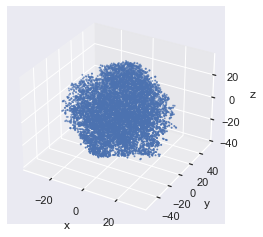

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "darkgrid")
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(embeddings[:,0], embeddings[:,1], embeddings[:,2], s=1)
plt.show()